In [3]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models


In [4]:
# GPU 설정 추가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.tight_layout()
    plt.show()
    


Train crack 이미지 개수: 17650


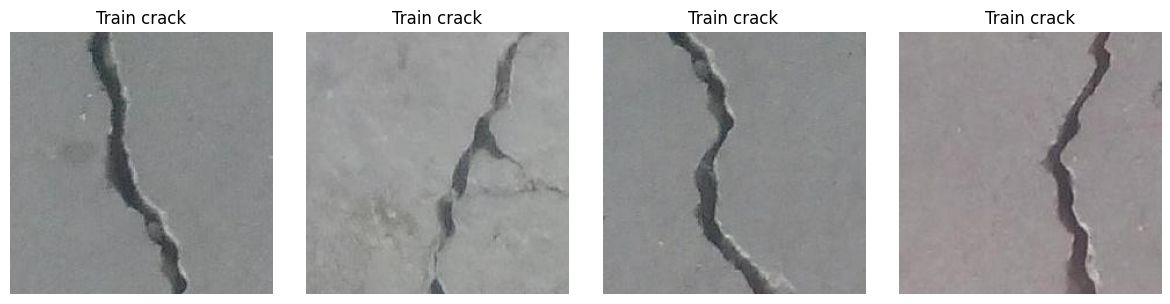

Train normal 이미지 개수: 17900


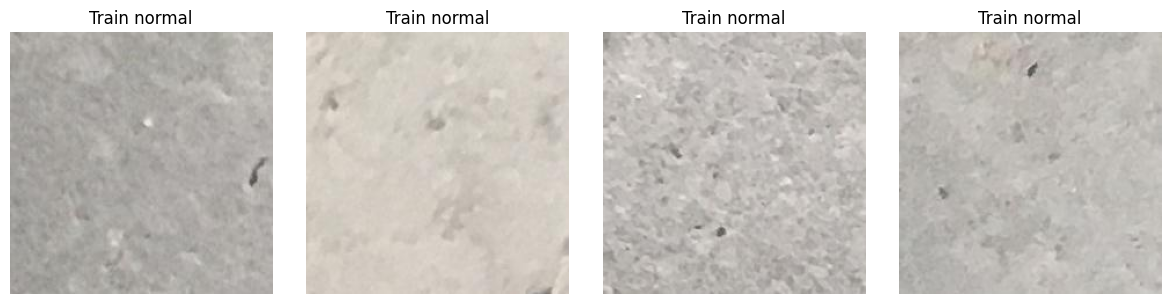

Val crack 이미지 개수: 1600


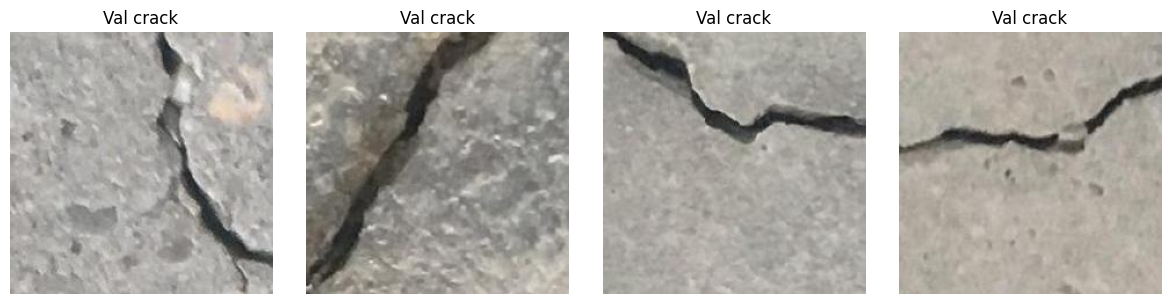

Val normal 이미지 개수: 1700


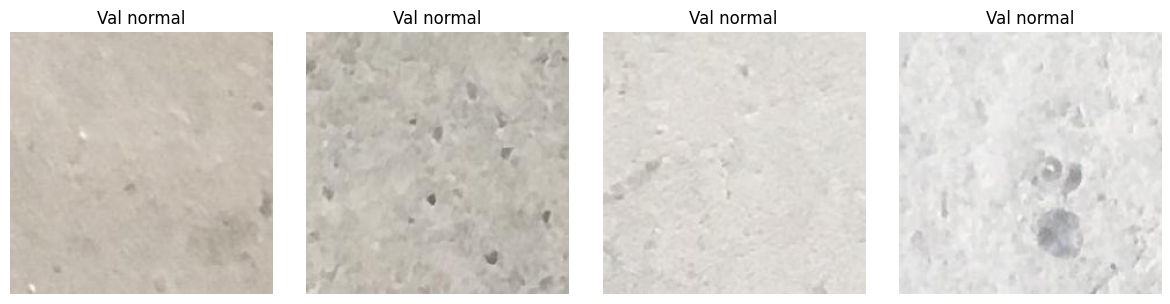

Test crack 이미지 개수: 100


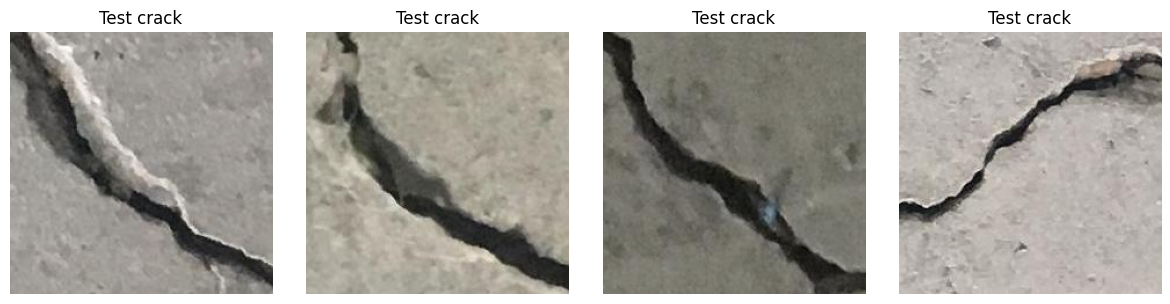

Test normal 이미지 개수: 100


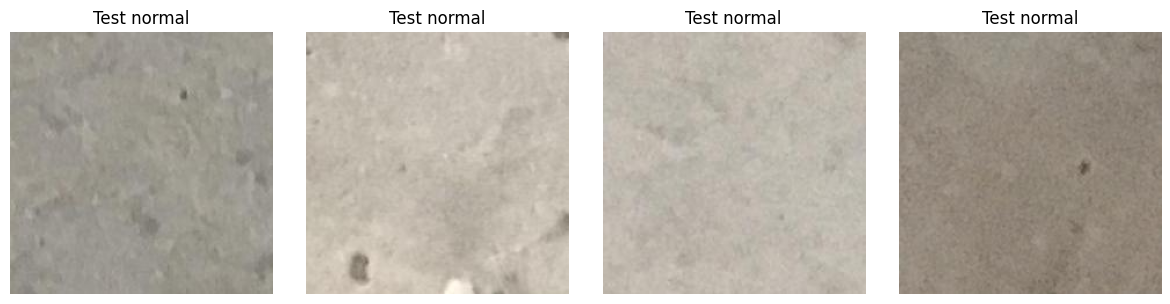

In [6]:
categories = ['Train crack', 'Train normal', 'Val crack', 'Val normal', 'Test crack', 'Test normal']

for category in categories:
    image_paths = glob.glob(f'../실습 파일/3/{category.lower().replace(" ","/")}/*')
    print(f'{category} 이미지 개수: {len(image_paths)}')
    display_images(image_paths, category)


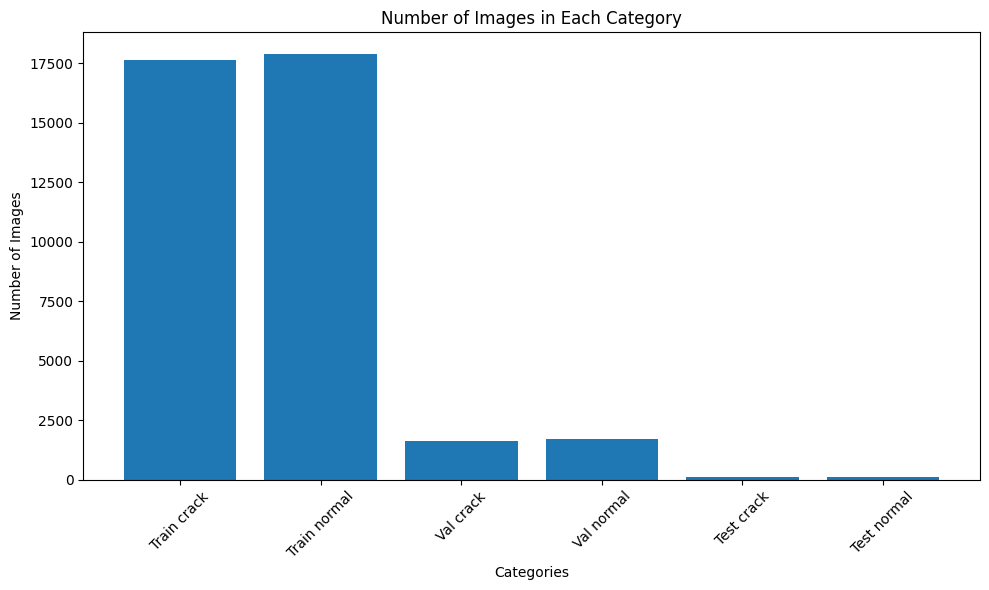

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'../실습 파일/3/{category.lower().replace(" ","/")}/*')) for category in categories])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [8]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])





In [9]:
train_dataset = ImageFolder(root='../실습 파일/3/train', transform=transform)
val_dataset = ImageFolder(root='../실습 파일/3/val', transform=transform)
test_dataset = ImageFolder(root='../실습 파일/3/test', transform=transform)

In [10]:
from torch.utils.data import SubsetRandomSampler
import numpy as np

num_of_train = len(train_dataset)
num_of_val = len(val_dataset)

train_indices = list(range(num_of_train))
val_indices = list(range(num_of_val))

np.random.shuffle(train_indices)
train_indices = train_indices[:int(num_of_train*0.8)]

np.random.shuffle(val_indices)
val_indices = val_indices[:int(num_of_val*0.2)]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, sampler=val_sampler)

In [11]:
# net = models.vgg19(pretrained=True)
# net
# VGG19 모델 초기화 및 GPU로 이동
net = models.vgg19(pretrained=True)
net = net.to(device)  # GPU로 모델 이동

c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for param in net.parameters():
    param.requires_grad = False

In [13]:
# net.classifier[6] = nn.Linear(4096, 2)
# net.classifier[6].requires_grad = True
net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True
net.classifier[6] = net.classifier[6].to(device)  # 새로운 분류기 층도 GPU로 이동


In [14]:
criterion = nn.CrossEntropyLoss()


In [15]:
import torch.optim as optim

def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(net.parameters(), lr=0.0001)
    else:
        raise ValueError(f"Invalid optimizer: {optimizer_name}")

    criterion = criterion.to(device)  # 손실 함수를 GPU로 이동

    # 학습/검증 손실과 정확도 기록
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)  # 입력 데이터를 GPU로
            labels = labels.to(device)  # 레이블을 GPU로
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # 정확도 계산
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
        # 검증
        net.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)  # 입력 데이터를 GPU로
                labels = labels.to(device)  # 레이블을 GPU로
                
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses:.4f}, Train Accuracy: {train_accuracies:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
    return train_losses, train_accuracies, val_losses, val_accuracies
            
            
        


In [16]:
train_losses_SGD, train_accuracies_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', net, train_loader, val_loader, criterion)


KeyboardInterrupt: 

In [ ]:
# 초기화

net = models.vgg19(pretrained=True)
for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True


In [ ]:
train_losses_Adam, train_accuracies_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', net, train_loader, val_loader, criterion)


In [ ]:
# 초기화

net = models.vgg19(pretrained=True)
for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True


In [ ]:
train_losses_AdamW, train_accuracies_AdamW, val_losses_AdamW, val_accuracies_AdamW = train_model('AdamW', net, train_loader, val_loader, criterion)


In [ ]:
# 초기화

net = models.vgg19(pretrained=True)
for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True


In [ ]:
train_losses_RAdam, train_accuracies_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', net, train_loader, val_loader, criterion)


In [ ]:
# 초기화

net = models.vgg19(pretrained=True)
for param in net.parameters():
    param.requires_grad = False

net.classifier[6] = nn.Linear(4096, 2)
net.classifier[6].requires_grad = True


In [ ]:
# 학습 손실과 검증 정확도 그래프

plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_AdamW, label='AdamW')
plt.plot(train_losses_RAdam, label='RAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)
plt.plot(val_losses_SGD, label='SGD', color='blue')
plt.plot(val_losses_Adam, label='Adam', color='red')
plt.plot(val_losses_AdamW, label='AdamW', color='green')
plt.plot(val_losses_RAdam, label='RAdam', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()








In [30]:
# Image load 및 tensor 변환

def load_and_transform_image(image_path, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image





In [32]:
class_folders = {
    'crack': '../실습 파일/3/test/crack',
    'normal': '../실습 파일/3/test/normal'
}




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565

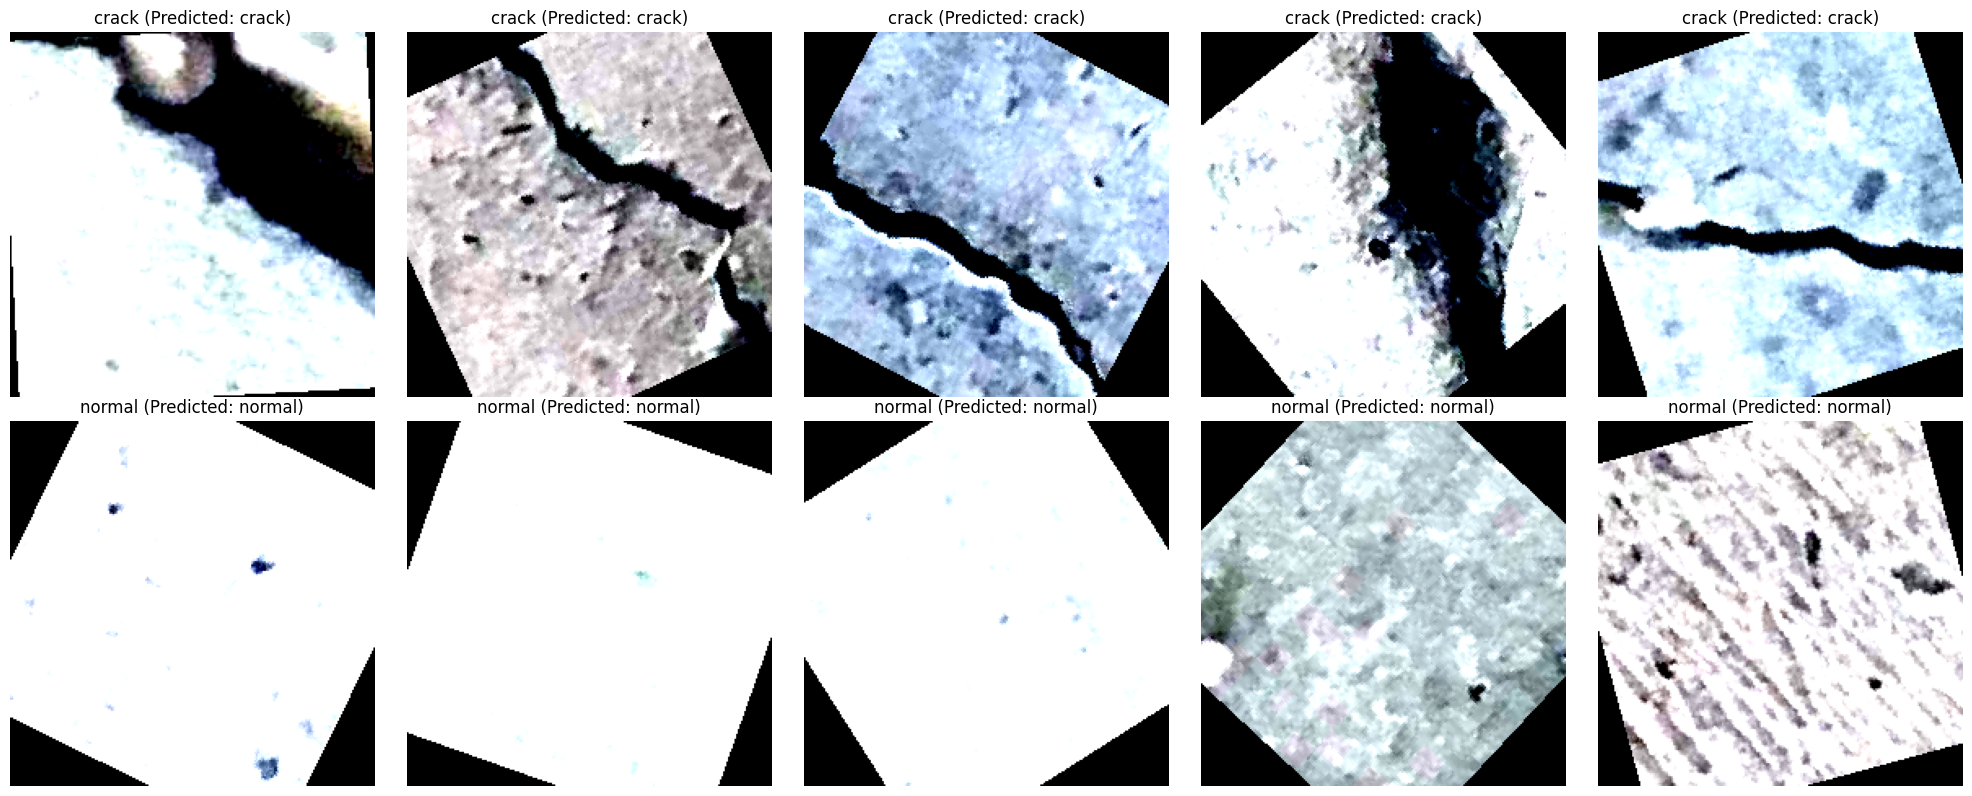

In [34]:
plt.figure(figsize=(20, 8))

counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = np.random.choice(image_paths, size=5, replace=False)
    
    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)
        
        net.eval()
        
        with torch.no_grad():
            outputs = net(image)
            _, predicted = torch.max(outputs, 1)
        prediction = 'crack' if predicted == 0 else 'normal'
        
        plt.subplot(2, 5, counter)
        plt.imshow(image.squeeze().permute(1, 2, 0))
        plt.title(f'{class_name} (Predicted: {prediction})')
        plt.axis('off')
        counter += 1

plt.tight_layout()
plt.show()

